In [6]:
import kagglehub
import pandas as pd

# Download latest version
path = kagglehub.dataset_download("fedesoriano/electric-power-consumption")

print("Path to dataset files:", path)

Path to dataset files: C:\Users\rgoud\.cache\kagglehub\datasets\fedesoriano\electric-power-consumption\versions\1


In [7]:
df = pd.read_csv(path+"\\powerconsumption.csv")
df = df[['Datetime', 'PowerConsumption_Zone1']]
df.head(10)

,Datetime,PowerConsumption_Zone1
0,1/1/2017 0:00,34055.69620
1,1/1/2017 0:10,29814.68354
2,1/1/2017 0:20,29128.10127
3,1/1/2017 0:30,28228.86076
4,1/1/2017 0:40,27335.69620
5,1/1/2017 0:50,26624.81013
6,1/1/2017 1:00,25998.98734
7,1/1/2017 1:10,25446.07595
8,1/1/2017 1:20,24777.72152
9,1/1/2017 1:30,24279.49367


In [17]:
import kagglehub
import pandas as pd

import numpy as np
import torch
from torch.utils.data import DataLoader, TensorDataset



def create_windows(data, input_length, output_length, stride=None):
    if stride is None:
        stride = input_length + output_length 
    X, y = [], []
    for i in range(0, len(data) - input_length - output_length + 1, stride):
        X.append(data[i:i + input_length])
        y.append(data[i + input_length:i + input_length + output_length])
    return np.array(X), np.array(y)




def check_for_invalid_data(X, dataset_name=""):
    invalid_samples = 0
    for idx, sample in enumerate(X):
        if np.all(np.isnan(sample)):  # Tous les éléments sont NaN
            print(f"Attention: L'échantillon {idx} dans {dataset_name} contient uniquement des NaNs.")
            invalid_samples += 1
        elif len(sample) == 0:  # Longueur zéro
            print(f"Attention: L'échantillon {idx} dans {dataset_name} a une longueur de zéro.")
            invalid_samples += 1
    print(f"Total d'échantillons invalides dans {dataset_name}: {invalid_samples}")

def get_electricity_data(batch_size=32, output_length=24):
    # Charger le dataset
    # Download latest version
    path = kagglehub.dataset_download("fedesoriano/electric-power-consumption")
    df = pd.read_csv(path+"\\powerconsumption.csv")
    df = df[['Datetime', 'PowerConsumption_Zone1']]
    
    # Extraire la série temporelle pour Zone 1
    time_series = df['PowerConsumption_Zone1'].values
    input_length = 144  # Dernier jour
    train_split = 0.6
    valid_split = 0.2

    n_points = len(time_series)
    train_end = int(train_split * n_points)
    valid_end = int((train_split + valid_split) * n_points)

    # Training
    train_data = time_series[:train_end]
    X_train, y_train = create_windows(train_data, input_length, output_length)

    # Validation
    valid_data = time_series[train_end:valid_end]
    X_valid, y_valid = create_windows(valid_data, input_length, output_length)

    # Test
    test_data = time_series[valid_end:]
    X_test, y_test = create_windows(test_data, input_length, output_length)

    # Vérification des données invalides
    check_for_invalid_data(X_train, "Training Data")
    check_for_invalid_data(X_valid, "Validation Data")
    check_for_invalid_data(X_test, "Test Data")

    # Conversion en tensors
    X_train_tensor = torch.tensor(X_train, dtype=torch.float32).unsqueeze(-1)
    y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(-1)
    X_valid_tensor = torch.tensor(X_valid, dtype=torch.float32).unsqueeze(-1)
    y_valid_tensor = torch.tensor(y_valid, dtype=torch.float32).unsqueeze(-1)
    X_test_tensor = torch.tensor(X_test, dtype=torch.float32).unsqueeze(-1)
    y_test_tensor = torch.tensor(y_test, dtype=torch.float32).unsqueeze(-1)

    train_loader = DataLoader(TensorDataset(X_train_tensor, y_train_tensor), batch_size=batch_size, shuffle=True, drop_last=True)
    valid_loader = DataLoader(TensorDataset(X_valid_tensor, y_valid_tensor), batch_size=batch_size, drop_last=True)
    test_loader = DataLoader(TensorDataset(X_test_tensor, y_test_tensor), batch_size=batch_size, drop_last=True)

    return train_loader, valid_loader, test_loader



Total d'échantillons invalides dans Training Data: 0
Total d'échantillons invalides dans Validation Data: 0
Total d'échantillons invalides dans Test Data: 0
Échantillons d'entraînement :


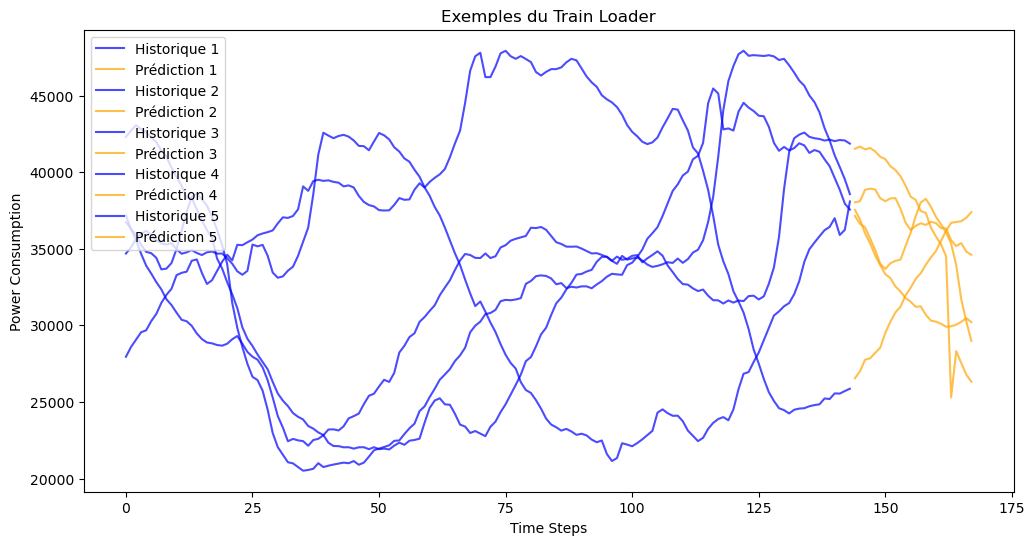

Échantillons de test :


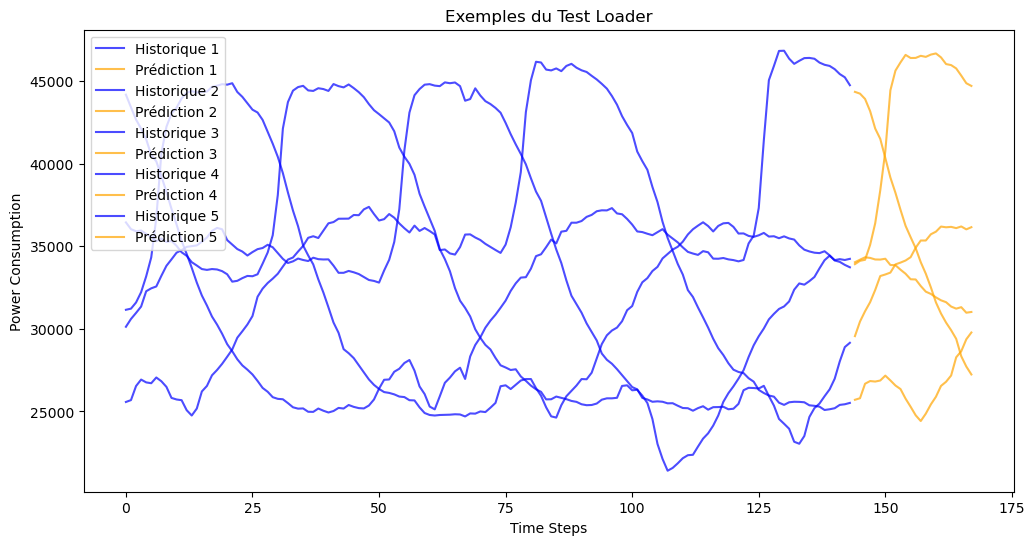

In [18]:
import matplotlib.pyplot as plt

def visualize_samples(train_loader, test_loader, num_samples=5):
    """
    Visualise des exemples d'échantillons des train et test loaders.
    Les parties historiques et à prédire sont affichées avec des couleurs différentes.
    """
    def plot_samples(loader, title):
        samples = iter(loader)
        X, y = next(samples)

        plt.figure(figsize=(12, 6))
        for i in range(min(num_samples, len(X))):
            history = X[i].squeeze().numpy()  # Historique
            future = y[i].squeeze().numpy()  # Prédiction

            plt.plot(range(len(history)), history, label=f"Historique {i+1}", color="blue", alpha=0.7)
            plt.plot(range(len(history), len(history) + len(future)), future, label=f"Prédiction {i+1}", color="orange", alpha=0.7)

        plt.title(title)
        plt.xlabel("Time Steps")
        plt.ylabel("Power Consumption")
        plt.legend(loc="upper left")
        plt.show()

    # Visualiser des échantillons d'entraînement
    print("Échantillons d'entraînement :")
    plot_samples(train_loader, "Exemples du Train Loader")

    # Visualiser des échantillons de test
    print("Échantillons de test :")
    plot_samples(test_loader, "Exemples du Test Loader")

train_loader, valid_loader, test_loader = get_electricity_data()
visualize_samples(train_loader, test_loader)
